In [25]:
from k_discount_var import kDISCount
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import seaborn as sns
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [26]:
model_name = 'clip-ViT-L-14'
model = SentenceTransformer(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
def generate_probs(query, temperature):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    cos_sims = util.cos_sim(img_emb, query_emb) / temperature
    probabilities = np.array(F.softmax(cos_sims, dim=0).cpu().numpy().flatten())
    return probabilities

def generate_gt(label, type_of_query):
    if type_of_query == 'direct':
        img_emb = torch.load(f'{model_name}_CUB.pt', map_location=device)
        num_images = len(img_emb)
        with open('img_names.pkl', 'rb') as f:
            img_names = pickle.load(f)
        
        f = np.zeros(num_images)
        
        bird_type = label
        
        for i, img in enumerate(img_names):
            if bird_type in img: f[i] = 1
        print(f'Positives: {sum(f)}')
        return f, img_emb, num_images
        
    elif type_of_query == 'attribute':
        img_emb = torch.load(f'{model_name}_CUB_F.pt', map_location=device)
        num_images = len(img_emb)
        attributes_path = 'attributes.txt'
        entries_path = 'image_attribute_labels.txt'

        attribute_name = label

        attribute_number = []
        with open(attributes_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if attribute_name in parts[1]:
                    attribute_number.append(int(parts[0]))

        if attribute_number is None:
            raise ValueError(f"Attribute '{attribute_name}' not found")

        print(f'Attribute Number(s): {attribute_number}')

        image_indices = set()
        with open(entries_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                image_number, attr_num, value = int(parts[0]), int(parts[1]), int(parts[2])
                if attr_num in attribute_number and value == 1:
                    image_indices.add(image_number - 1)

        idx = list(image_indices)
        f = np.zeros(num_images)
        f[idx] = 1
        print(f'Positives: {sum(f)}')
        return f, img_emb, num_images

In [28]:
query = 'A photo of a yellow colored bird'

In [29]:
# Ground truth generation - ONLY if the query is an attribute
label = 'has_primary_color::yellow'
type_of_query = 'attribute'

# # Ground truth generation - ONLY if the query is a species (class)
# label = 'Horned_Lark'
# type_of_query = 'direct'

f, img_emb, num_images = generate_gt(label, type_of_query)

Positives: 60.0


In [30]:
def train_logreg(
    x_train,
    y_train,
    X_predict,
    y_predict,
    n_epochs=10,
    weight_decay=1e-1,
    lr=1.0e-2,
):
    x_train = torch.tensor(x_train).float().to(device)
    y_train = torch.tensor(y_train).long().to(device)
    X_predict = torch.tensor(X_predict).float().to(device)
    y_predict = torch.tensor(y_predict).long().to(device)

    # Define the model dimension and send the model to the device
    d = x_train.shape[1]
    model = nn.Linear(d, 2).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            with torch.no_grad():
                predicted_classes = torch.argmax(outputs, dim=1)
                precision = precision_score(y_train.cpu(), predicted_classes.cpu(), zero_division=0)
                recall = recall_score(y_train.cpu(), predicted_classes.cpu())
                # print(f"Epoch {epoch + 1}: Precision = {precision:.4f}, Recall = {recall:.4f} (on test)")

    model.eval()
    with torch.no_grad():
        outputs = model(X_predict)
        predicted_classes = torch.argmax(outputs, dim=1)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

    # cm = confusion_matrix(y_predict.cpu().numpy(), predicted_classes.cpu().numpy())
    return probs

def sufficient_samples(labels, minimum_count=2):
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    return all(count >= minimum_count for count in label_counts.values())

In [31]:
# Define hyperparameters
eps = 1e-4
temperatures = np.array([0.1])
reg = 0.001 if type_of_query == 'direct' else 0.1  # Regularization term for the linear classifier
weights = 'var' if type_of_query == 'direct' else 'split'
split_values = np.array([0.1, 0.5, 0.9])
n_values = np.arange(200, 1001, 100)
repetitions = 100

In [32]:
num_images = len(f)
ground_truth = sum(f)

# Uniform
g_uni = np.full(num_images, 1 / num_images)

# Initialize data structures to store results
mean_percentage_errors = {temp: [] for temp in temperatures}
mean_percentage_error_lower_bounds = {temp: [] for temp in temperatures}
mean_percentage_error_upper_bounds = {temp: [] for temp in temperatures}

# Adaptive estimator results initialized for each temperature
AS_results = {
    split: {
        temp: {
            'mean_percentage_errors_AS': [],
            'mean_percentage_error_lower_bounds_AS': [],
            'mean_percentage_error_upper_bounds_AS': [],
        } for temp in temperatures
    } for split in split_values
}

# Uniform estimator results
mean_percentage_errors_UNI = []
mean_percentage_error_lower_bounds_UNI = []
mean_percentage_error_upper_bounds_UNI = []

for n in n_values:
    print(f'Processing n={n}')
    
    for temp in temperatures:
        
        # DISCount setup for current temperature
        percentage_errors_temp = []
        percentage_error_lower_bounds_temp = []
        percentage_error_upper_bounds_temp = []

        # Repeat for uniform estimator
        percentage_errors_UNI_temp = []
        percentage_error_lower_bounds_UNI_temp = []
        percentage_error_upper_bounds_UNI_temp = []
    
        g = generate_probs(query, temp)  # Generate probability distribution for current temperature
    
        for split in split_values:

            # Adaptive Sampling setup for current temperature
            percentage_errors_AS_temp = []
            percentage_error_lower_bounds_AS_temp = []
            percentage_error_upper_bounds_AS_temp = []
        
            for _ in tqdm.tqdm(range(repetitions), desc=f'AS: Temperature {temp}, Split {split}'):
                
                n_split = int(n*split)
                        
                estimator_AS = kDISCount(g, g, eps)  # Use temperature-based proposal for AS
                samples_as = estimator_AS.sample(n=n_split)
                screened_samples_as = [f[i] for i in samples_as]
                if not sufficient_samples(screened_samples_as): 
                    # print('Insufficient Positive/Negative Samples, skipping')
                    continue
                estimator_AS.load(screened_samples_as)
                F_hat_temp, CI_temp, Var_hat_temp = estimator_AS.estimate([[i for i, _ in enumerate(g)]])
                estimate_pre = F_hat_temp[0]
                variance_pre = Var_hat_temp[0]
                
                X_train = img_emb[samples_as]
                y_train = np.array(f[samples_as])

                all_indices = np.arange(len(g))
                unscreend_indices = np.setdiff1d(all_indices, samples_as)
                X_predict = img_emb[unscreend_indices]
                y_predict = f[unscreend_indices]

                all_indices = np.arange(len(g))
                unscreend_indices = np.setdiff1d(all_indices, samples_as)

                # Get predictions (probabilities)
                predictions_unscreend = train_logreg(X_train, y_train, X_predict, y_predict, weight_decay=reg, n_epochs=1000)
          
                # Continue with the modified predictions
                new_g = np.array([None] * len(g))
                for idx, actual_value in zip(samples_as, screened_samples_as):
                    new_g[idx] = actual_value
                for idx, pred_value in zip(unscreend_indices, predictions_unscreend):
                    new_g[idx] = pred_value
                    
                new_g = (new_g).astype(float)
                new_g += eps
                norm = new_g.sum()
                new_g = new_g/norm
    
                estimator_linear = kDISCount(new_g, new_g, eps)
                n_linear = n - n_split
                samples_linear = estimator_linear.sample(n = n_linear)
                screened_samples_linear = [f[i] for i in samples_linear]
                estimator_linear.load(screened_samples_linear)
                F_hat_temp, CI_temp, Var_hat_temp = estimator_linear.estimate([[i for i, _ in enumerate(new_g)]])
                estimate_post = F_hat_temp[0]
                variance_post = Var_hat_temp[0]
                
                if weights == 'var':
                    # Variance based weights
                    weight1 = 1 / variance_pre
                    weight2 = 1 / variance_post
                    estimate_weighted = (weight1 * estimate_pre + weight2 * estimate_post) / (weight1 + weight2)  
        
                elif weights == 'split':
                    # Sample-ratio based weights (pick one)
                    estimate_weighted = split*estimate_pre + (1-split)*estimate_post
                
                perc_error_AS = abs(estimate_weighted - ground_truth) / ground_truth * 100
                perc_error_lb_AS = abs(estimate_weighted - CI_temp[0] - ground_truth) / ground_truth * 100
                perc_error_ub_AS = abs(estimate_weighted + CI_temp[0] - ground_truth) / ground_truth * 100

                percentage_errors_AS_temp.append(perc_error_AS)
                percentage_error_lower_bounds_AS_temp.append(perc_error_lb_AS)
                percentage_error_upper_bounds_AS_temp.append(perc_error_ub_AS)
            
            # Store mean errors for AS at current temperature
            AS_results[split][temp]['mean_percentage_errors_AS'].append(np.nanmean(percentage_errors_AS_temp))
            AS_results[split][temp]['mean_percentage_error_lower_bounds_AS'].append(np.nanmean(percentage_error_lower_bounds_AS_temp))
            AS_results[split][temp]['mean_percentage_error_upper_bounds_AS'].append(np.nanmean(percentage_error_upper_bounds_AS_temp))
       
        
        for _ in tqdm.tqdm(range(repetitions), desc=f'DIS: Temperature {temp}'):

            estimator_temp = kDISCount(g, g, eps)
            samples_temp = estimator_temp.sample(n=n)
            screened_samples_temp = [f[i] for i in samples_temp]
            estimator_temp.load(screened_samples_temp)
            F_hat_temp, CI_temp, Var_hat_temp = estimator_temp.estimate([[i for i, _ in enumerate(g)]])

            # Calculate errors for temperature-based estimation
            perc_error_temp = abs(F_hat_temp[0] - ground_truth) / ground_truth * 100
            perc_error_lb_temp = abs(F_hat_temp[0] - CI_temp[0] - ground_truth) / ground_truth * 100
            perc_error_ub_temp = abs(F_hat_temp[0] + CI_temp[0] - ground_truth) / ground_truth * 100

            percentage_errors_temp.append(perc_error_temp)
            percentage_error_lower_bounds_temp.append(perc_error_lb_temp)
            percentage_error_upper_bounds_temp.append(perc_error_ub_temp)

        # Store mean errors for current temperature
        mean_percentage_errors[temp].append(np.nanmean(percentage_errors_temp))
        mean_percentage_error_lower_bounds[temp].append(np.nanmean(percentage_error_lower_bounds_temp))
        mean_percentage_error_upper_bounds[temp].append(np.nanmean(percentage_error_upper_bounds_temp))


    for _ in tqdm.tqdm(range(repetitions), desc='Uniform'):

        estimator_UNI = kDISCount(g_uni, g_uni, eps)
        samples_uni = estimator_UNI.sample(n=n)
        screened_samples_uni = [f[i] for i in samples_uni]
        estimator_UNI.load(screened_samples_uni)
        F_hat_uni, CI_uni, Var_hat_uni = estimator_UNI.estimate([[i for i, _ in enumerate(g)]])

        perc_error_UNI = abs(F_hat_uni[0] - ground_truth) / ground_truth * 100
        perc_error_lb_UNI = abs(F_hat_uni[0] - CI_uni[0] - ground_truth) / ground_truth * 100
        perc_error_ub_UNI = abs(F_hat_uni[0] + CI_uni[0] - ground_truth) / ground_truth * 100

        percentage_errors_UNI_temp.append(perc_error_UNI)
        percentage_error_lower_bounds_UNI_temp.append(perc_error_lb_UNI)
        percentage_error_upper_bounds_UNI_temp.append(perc_error_ub_UNI)

    # Store mean errors for uniform estimator
    mean_percentage_errors_UNI.append(np.nanmean(percentage_errors_UNI_temp))
    mean_percentage_error_lower_bounds_UNI.append(np.nanmean(percentage_error_lower_bounds_UNI_temp))
    mean_percentage_error_upper_bounds_UNI.append(np.nanmean(percentage_error_upper_bounds_UNI_temp))

Processing n=300


AS: Temperature 0.1, Split 0.5:   0%|          | 0/10 [00:00<?, ?it/s]

Processing n=600


AS: Temperature 0.1, Split 0.5:   0%|          | 0/10 [00:00<?, ?it/s]

Processing n=900


Uniform: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


In [33]:
print(AS_results[split][temp]['mean_percentage_errors_AS'])

[7.078726190285121, 5.896870606422097, 4.169009205858392]


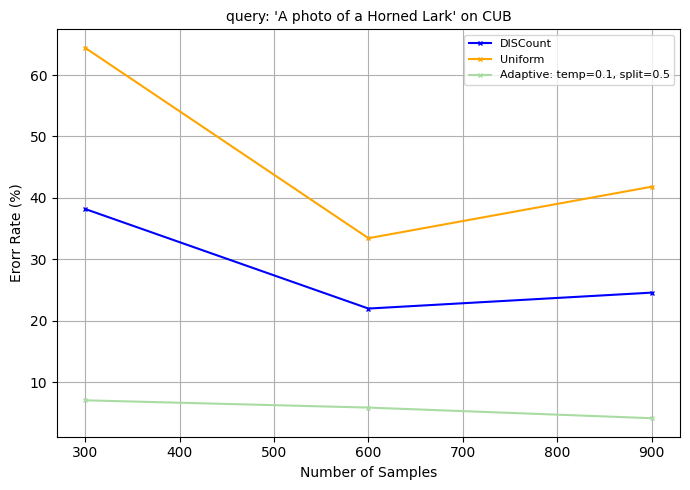

In [34]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(1, 1)
ax4 = fig.add_subplot(gs[0, 0])

num_splits = len(split_values)
colors_adaptive = plt.cm.Greens(np.linspace(0.35, 0.75, num_splits))

for i, temp in enumerate(temperatures):
    ax4.plot(n_values, mean_percentage_errors[temp], label=f'DISCount', color='blue', marker='x', markersize=3, linestyle='-')
    
ax4.plot(n_values, mean_percentage_errors_UNI, label=f'Uniform', color='orange', marker='x', markersize=3, linestyle='-')

# Adaptive plots
for i, temp in enumerate(temperatures):
    for j, split in enumerate(split_values):
        ax4.plot(n_values, AS_results[split][temp]['mean_percentage_errors_AS'], label=f'Adaptive: temp={temp}, split={split}', color=colors_adaptive[j], marker='x', markersize=3, linestyle='-')

ax4.set_xlabel('Number of Samples')
ax4.set_ylabel('Erorr Rate (%)')
ax4.set_title(f"query: '{query}' on CUB", fontsize=10)
ax4.legend(loc='upper right', fontsize=8)
plt.grid(True)

plt.tight_layout()

# # Serialize the figure to a file
# with open('{name}.pickle', 'wb') as file:
#     pickle.dump(fig, file)

plt.show(fig)